In [1]:
import numpy as np
import igl
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.colors
import mpl_toolkits.mplot3d 
from icosphere import icosphere
import math

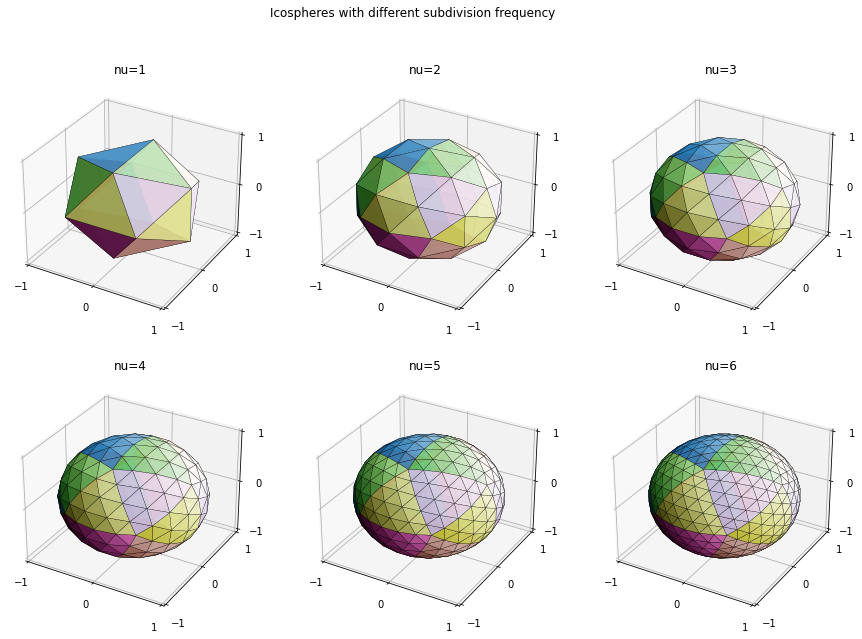

In [2]:
# source: https://github.com/vedranaa/icosphere/blob/main/Example_in_matplotlib.ipynb

fig = plt.figure(figsize=(15, 10))
for nu in range(1,7):

    vertices, faces = icosphere(nu=nu)
    
    # basic mesh color, divided in 20 groups (one for each original face)
    jet = matplotlib.cm.tab20(np.linspace(0,1,20))
    jet = np.tile(jet[:,:3], (1, faces.shape[0]//20))
    jet = jet.reshape(faces.shape[0], 1, 3)

    # computing face shading intensity based on face normals  
    face_normals = np.cross(vertices[faces[:,1]]-vertices[faces[:,0]], 
                            vertices[faces[:,2]]-vertices[faces[:,0]])
    face_normals /= np.sqrt(np.sum(face_normals**2, axis=1, keepdims=True))               
    light_source = matplotlib.colors.LightSource(azdeg=60, altdeg=30)
    intensity = light_source.shade_normals(face_normals)

    # blending face colors and face shading intensity
    rgb = light_source.blend_hsv(rgb=jet, intensity=intensity.reshape(-1,1,1))   

    # adding alpha value, may be left out
    rgba = np.concatenate((rgb, 0.9*np.ones(shape=(rgb.shape[0],1,1))), axis=2) 

    # creating mesh with given face colors
    poly = mpl_toolkits.mplot3d.art3d.Poly3DCollection(vertices[faces])
    poly.set_facecolor(rgba.reshape(-1,4)) 
    poly.set_edgecolor('black')
    poly.set_linewidth(0.25)

    # and now -- visualization! 
    ax = fig.add_subplot(2,3,nu, projection='3d')                  

    ax.add_collection3d(poly) 
        
    ax.set_xlim(-1,1)
    ax.set_ylim(-1,1)
    ax.set_zlim(-1,1)
    
    ax.set_xticks([-1,0,1])
    ax.set_yticks([-1,0,1])
    ax.set_zticks([-1,0,1])
    
    ax.set_title(f'nu={nu}')

fig.suptitle('Icospheres with different subdivision frequency')
plt.show()

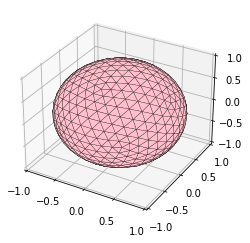

In [3]:
n = 7
vertices, faces = icosphere(n)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

sphere = mpl_toolkits.mplot3d.art3d.Poly3DCollection(vertices[faces])
sphere.set_facecolor('pink')
sphere.set_edgecolor('black')
sphere.set_linewidth(0.25)

ax.add_collection3d(sphere)

ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.set_zlim(-1,1)
plt.show()

In [4]:
# Geodetic distance between two points 
print(vertices.shape, faces.shape)

vertices = vertices.astype(float)
faces = faces.astype(int)

vs, vt = np.random.randint(0, len(vertices), 2)
fs, ft = np.random.randint(0, len(faces), 2)

vs, vt, fs, ft = np.array([vs]), np.array([vt]), np.array([fs]), np.array([ft])

# finding the shortest path between the two points
dist = igl.exact_geodesic(vertices, faces, vs, vt)
print(dist)


(492, 3) (980, 3)
2.3167898240531475


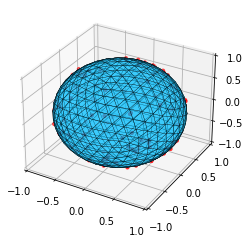

In [5]:
# Distance fields
# Generate some sample points
def samples(n):
    # Generating z coordinates with radius = 1
    z = np.random.uniform(-1,1,n)

    # Generating azimuthal angles
    phi = np.random.uniform(0,2*math.pi,n)

    # Generating x and y coordinates
    x = np.sqrt(1-z**2)*np.cos(phi)
    y = np.sqrt(1-z**2)*np.sin(phi)
    samples = np.array([x,y,z]).T
    return samples

points = samples(100)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

sphere = mpl_toolkits.mplot3d.art3d.Poly3DCollection(vertices[faces])
sphere.set_facecolor('deepskyblue')
sphere.set_edgecolor('black')
sphere.set_alpha(0.5)
sphere.set_linewidth(0.25)

ax.add_collection3d(sphere)
ax.scatter(points[:,0], points[:,1], points[:,2], c='red', s=10)

ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.set_zlim(-1,1)
plt.show()


In [6]:

# Compute the signed distance and closest face for each poin

def pairDistances(samples, vertices, faces):

    npts = np.shape(samples)[0]
    dist = []

    # get the smallest distance faces
    signed_dist = igl.signed_distance(samples, vertices, faces)
    pointToface = signed_dist[1]

    # loop through all pair and compute distance
    for i in range(npts):
        for j in range(i+1, npts):
            fs = np.array(pointToface[i])
            ft = np.array(pointToface[j])
            d = igl.exact_geodesic(vertices, faces, fs, ft)
            dist.append(d)
            # print(fs, ft, d)
    return dist


# Calculating the distance between all pairs of points
def surfaceArea(r):
    area = 4 * math.pi * r**2
    return area


def ripleyK(r, data, vertices, faces, radii):
    K = np.zeros_like(radii)
    area = surfaceArea(r)
    dist = pairDistances(data, vertices, faces)
    pair_num = len(dist)
    intensity = pair_num / area
    for i in range(len(radii)):
        K[i] = np.sum(dist < radii[i])
    K = K / intensity
    return K

0.0
[158 532 350 158 173 111 561 111  54 899 760 258 491 906 102 832 639 926
 818 389 920 350 304 325 821 663 746 871 496 822 810 668 361 667 142 946
 145 959 471 976 396  43 515 743 400 402 461 314  98 602 399  25 152 700
 774   3  94 717 901 277 302 684 812 595 175  32 820 813 477 732 972 596
 743 580 847 315 294 496 128 946 694 898 545 442 540 475  31 487 845 690
 227 393 160 620 333 299 104 862 812 587]


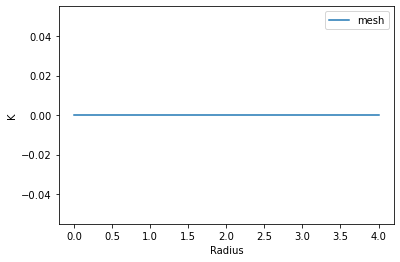

In [8]:
radii = np.linspace(0, 4, 50)

d = igl.signed_distance(points, vertices, faces)
fs = np.array([158])
ft = np.array([532])
dist = igl.exact_geodesic(vertices, faces, fs, ft)
print(dist)
print(d[1])

pdist = pairDistances(points, vertices, faces)

kt = ripleyK(1, points, vertices, faces, radii)


# Plotting the Ripley's K function
plt.plot(radii, kt, label='mesh')
plt.xlabel('Radius')
plt.ylabel('K')
plt.legend()
plt.show()